# Comparison of methods

In this first part, we will use the pre-computed empirical similarities between each pairwise method and compare them.

The idea is to get an understanding of how each method relates to one another using clustering techniques.

In order to re-compute the empirical similarity between each pairwise method, use the `process_mts_database.py` script (although this may not be feasible on a standard laptop).

In [2]:
import pandas
import numpy
import random

random.seed(1)

mm_adj = pandas.read_csv('data/mm_adj.csv',header=0,index_col=0)
statnames = mm_adj.columns

numpy.fill_diagonal(mm_adj.values,numpy.nan)
mm_adj

,anm,bary_dtw_max,bary_dtw_mean,bary_euclidean_max,bary_sgddtw_max,bary_sgddtw_mean,bary_softdtw_max,bary_softdtw_mean,cce_gaussian,cce_kernel_W-0.5,...,tlmi_kraskov_NN-4_DCE,wpli_multitaper_max_fs-1_fmin-0-25_fmax-0-5,wpli_multitaper_max_fs-1_fmin-0_fmax-0-25,wpli_multitaper_max_fs-1_fmin-0_fmax-0-5,wpli_multitaper_mean_fs-1_fmin-0-25_fmax-0-5,wpli_multitaper_mean_fs-1_fmin-0_fmax-0-25,wpli_multitaper_mean_fs-1_fmin-0_fmax-0-5,xcorr_max_sig-True,xcorr_mean_sig-False,xcorr_mean_sig-True
Source statistic,,,,,,,,,,,,,,,,,,,,,
anm,NaN,1.628389e-01,1.548281e-01,1.687260e-01,1.607370e-01,1.462287e-01,1.626091e-01,1.671775e-01,0.214995,0.217163,...,2.071107e-01,0.098217,0.100187,0.096365,9.111911e-02,9.192455e-02,9.626877e-02,1.988005e-01,1.838997e-01,1.795069e-01
bary_dtw_max,0.162839,NaN,2.027443e-01,6.477474e-01,6.559101e-01,1.923402e-01,7.511788e-01,2.298296e-01,0.207820,0.144580,...,2.303810e-01,0.088809,0.086540,0.092968,9.483721e-10,1.744748e-09,9.460279e-09,2.893172e-01,2.543113e-01,2.424879e-01
bary_dtw_mean,0.154828,2.027443e-01,NaN,2.161415e-01,2.092053e-01,5.457060e-01,1.926368e-01,2.678172e-01,0.169504,0.120563,...,2.302929e-01,0.087658,0.088871,0.088465,1.735360e-09,3.354771e-09,5.990267e-09,2.572616e-01,2.089434e-01,2.107027e-01
bary_euclidean_max,0.168726,6.477474e-01,2.161415e-01,NaN,8.016686e-01,2.151985e-01,5.309159e-01,2.397957e-01,0.206122,0.145503,...,2.375066e-01,0.094711,0.086462,0.094679,5.098559e-09,7.422641e-09,5.203952e-09,3.092295e-01,2.316964e-01,2.334032e-01
bary_sgddtw_max,0.160737,6.559101e-01,2.092053e-01,8.016686e-01,NaN,2.134298e-01,5.643723e-01,2.350540e-01,0.205290,0.148867,...,2.367219e-01,0.094533,0.084933,0.092692,9.302393e-09,6.924543e-09,2.028296e-08,3.091696e-01,2.450937e-01,2.430105e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wpli_multitaper_mean_fs-1_fmin-0_fmax-0-25,0.091925,1.744748e-09,3.354771e-09,7.422641e-09,6.924543e-09,2.859906e-08,3.845515e-09,6.420359e-09,0.124151,0.166450,...,3.876893e-09,0.175466,0.482224,0.331378,2.762827e-01,NaN,7.212857e-01,1.528278e-08,3.905387e-08,1.510396e-08
wpli_multitaper_mean_fs-1_fmin-0_fmax-0-5,0.096269,9.460279e-09,5.990267e-09,5.203952e-09,2.028296e-08,3.233039e-08,3.005142e-09,2.789995e-09,0.127715,0.155272,...,1.176972e-08,0.372940,0.380380,0.409245,7.014512e-01,7.212857e-01,NaN,3.993953e-08,2.558771e-08,2.946789e-08
xcorr_max_sig-True,0.198801,2.893172e-01,2.572616e-01,3.092295e-01,3.091696e-01,2.521785e-01,2.608345e-01,3.027015e-01,0.311062,0.180657,...,3.941087e-01,0.105165,0.103215,0.107940,8.972725e-09,1.528278e-08,3.993953e-08,NaN,2.891007e-01,3.439773e-01


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.cluster import hierarchy

method = 'weighted'

y = 1 - mm_adj.fillna(0).values[numpy.triu_indices(mm_adj.shape[0], 1)]
Z = hierarchy.linkage(y, metric='euclidean', method=method, optimal_ordering=True)

threshold = 0.76
clusters = hierarchy.fcluster(Z, threshold, criterion='distance')
nclusters = numpy.unique(clusters).size

cm = numpy.genfromtxt('data/cmap.csv', delimiter=',')
cmap = [matplotlib.colors.rgb2hex(c/255+(0,)) for c in cm]

hierarchy.set_link_color_palette(cmap)

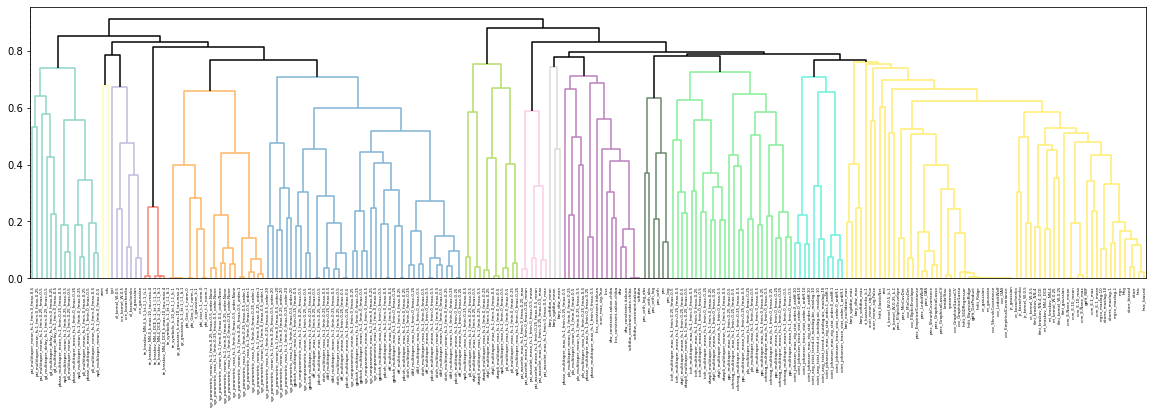

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))
dn = hierarchy.dendrogram(Z, labels=statnames, orientation='top',
                            color_threshold=threshold, leaf_font_size=4,
                            count_sort='ascending', above_threshold_color='k')
plt.axvline(x=threshold, c='grey', lw=1, linestyle='dashed')

In [5]:
# Wrapper functions for network generation using networkx
import networkx

def _reweight(x, thresholds=(0.75,0.5,0.25), weights=(2,0.75,0.1)):
    for t, w in zip(thresholds, weights):
        if x >= t:
            return w
    return 0

def _nudge(pos, x_shift, y_shift):
    return {n: (x + x_shift, y + y_shift) for n, (x,y) in pos.items()}

def draw_network(adj, spi=None, squared=False, node_color=None, \
                 color_labels=None, labels_on=False, pos=None, \
                 layout='spring', seed=1, use_kk=True, savedir=None, \
                 thresholds=None, weights=None, alpha=None, figsize=(12,10)):

    adj = adj.copy(deep=True).fillna(0)

    if thresholds is None:
        if adj.shape[0] < 50:
            thresholds = (0.9,0.7,0.5)
        else:
            vec = adj.values[numpy.triu_indices(adj.shape[0],1)]
            thresholds = numpy.percentile(vec[~numpy.isnan(vec)], [99, 95, 90])

    if weights is None:
        weights = (2,0.75,0.1)

    if squared:
        adj = adj**2
        thresholds = [t**2 for t in thresholds]

    if alpha is None:
        alpha = 1

    if node_color is None:
        node_color = {s: (0., 0., 0.) for s in adj}
    else:
        # If any nodes aren't in the map, set them to black
        for spi in adj:
            node_color.setdefault(spi, (0., 0., 0.))

    G = networkx.from_pandas_adjacency(adj)

    if spi is not None:
        fig, ax = plt.subplots(1, figsize=figsize)

        if layout == 'spring':
            if pos is None:
                if use_kk:
                    pos = networkx.kamada_kawai_layout(G)
                else:
                    pos = None
            pos = networkx.spring_layout(G,pos=pos,seed=seed,iterations=1000)
        elif pos is None:
            raise ValueError('pos must be included if layout is not spring.')

        weights = [_reweight(G[u][v]['weight'], thresholds, weights) for u, v in G.edges()]

        networkx.draw(G, pos=pos, ax=ax, with_labels=False, node_size=250,
                        edgecolors='k', edge_color=None, width=weights,
                        node_color=[node_color[f] for f in pos], alpha=alpha)

        pos_labels = _nudge(pos, 0,0.02)
        if labels_on:
            networkx.draw_networkx_labels(G, pos=pos_labels, ax=ax, font_size=6)
            plt.margins(x=0.4)
    else:
        fig, ax = plt.subplots(1, figsize=figsize)
        weights = [_reweight(G[u][v]['weight'], thresholds, weights) for u, v in G.edges()]

        if layout == 'spring':
            if use_kk:
                pos = networkx.kamada_kawai_layout(G)
            else:
                pos = None
            pos = networkx.spring_layout(G, seed=seed, pos=pos, iterations=1000)
        elif pos is None:
            raise ValueError('pos must be included if layout is not spring.')

        networkx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=150,
                                            edgecolors=[[0.8*c for c in node_color[f]] for f in pos],
                                            node_color=[node_color[f] for f in pos],
                                            linewidths=1, alpha=alpha)
        networkx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=None, width=weights, alpha=alpha)

        if labels_on:
            networkx.draw_networkx_labels(G, pos=pos, ax=ax, font_size=1)
            plt.margins(x=0.4)
        
    ax = plt.gca()
    if color_labels is not None:
        ns = []
        for l in color_labels:
            ns.append(ax.scatter([], [], color=color_labels[l], label=l))

        lines = []
        for t, w in zip(thresholds, weights):
            if squared:
                l, = ax.plot([],[], color='k', linewidth=w, label=f'|r| > {numpy.sqrt(t):.2f}')
            else:
                l, = ax.plot([],[], color='k', linewidth=w, label=f'|r| > {t:.2f}')
            lines.append(l)
        legend1 = plt.legend(lines,[l.get_label() for l in lines],loc=3)
        ax.legend(ns,[n.get_label() for n in ns], loc=1)
        ax.add_artist(legend1)

    plt.tight_layout()
    plt.axis('off')

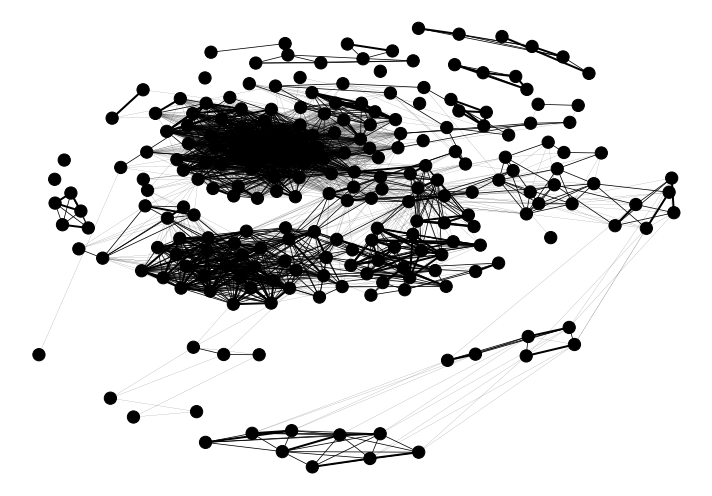

In [6]:
# Network without module colours can be difficult to interpret..
draw_network(mm_adj, squared=True, figsize=(10, 7))

In [7]:
# ...so let's get the colours of each node and cluster for re-plotting
try:
    colour_list = dn["leaves_color_list"]
except KeyError:
    # The legacy versions of scipy don't have the leaves_color_list output
    def _get_leaves_color_list(R):
        leaves_color_list = [None] * len(R['leaves'])
        for link_x, link_y, link_color in zip(R['icoord'],
                                            R['dcoord'],
                                            R['color_list']):
            for (xi, yi) in zip(link_x, link_y):
                if yi == 0.0:  # if yi is 0.0, the point is a leaf
                    # xi of leaves are      5, 15, 25, 35, ... (see `iv_ticks`)
                    # index of leaves are   0,  1,  2,  3, ... as below
                    leaf_index = (int(xi) - 5) // 10
                    # each leaf has a same color of its link.
                    leaves_color_list[leaf_index] = link_color
        return leaves_color_list

    dn['leaves_color_list'] = _get_leaves_color_list(dn)
    colour_list = dn['leaves_color_list']

node_colours = {s : matplotlib.colors.hex2color(c) for s, c in zip(dn["ivl"], dn["leaves_color_list"])}
node_colours

['#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#8cd4c7',
 '#fefeb3',
 '#fefeb3',
 '#bfbbdc',
 '#bfbbdc',
 '#bfbbdc',
 '#bfbbdc',
 '#bfbbdc',
 '#bfbbdc',
 '#bfbbdc',
 '#fa7f72',
 '#fa7f72',
 '#fa7f72',
 '#fa7f72',
 '#fa7f72',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#fdb562',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#80b1d2',
 '#8

In [8]:
_, uidx = numpy.unique(colour_list, return_index=True)
unique_modules = numpy.array(colour_list)[numpy.sort(uidx)]

module_colours = {f'M{i+1:02d}' : matplotlib.colors.hex2color(c) for i, c in enumerate(unique_modules)}

module_colours['Singleton'] = (0,0,0)
del module_colours[[k for k, v in zip(module_colours.keys(), module_colours.values()) if v == (0,0,0)][0]]
module_colours

{'M01': (0.5490196078431373, 0.8313725490196079, 0.7803921568627451),
 'M02': (0.996078431372549, 0.996078431372549, 0.7019607843137254),
 'M03': (0.7490196078431373, 0.7333333333333333, 0.8627450980392157),
 'M04': (0.9803921568627451, 0.4980392156862745, 0.4470588235294118),
 'M05': (0.9921568627450981, 0.7098039215686275, 0.3843137254901961),
 'M06': (0.5019607843137255, 0.6941176470588235, 0.8235294117647058),
 'M07': (0.6980392156862745, 0.8666666666666667, 0.40784313725490196),
 'M08': (0.984313725490196, 0.803921568627451, 0.9019607843137255),
 'M09': (0.8549019607843137, 0.8549019607843137, 0.8549019607843137),
 'M10': (0.7294117647058823, 0.4980392156862745, 0.7372549019607844),
 'M11': (0.40784313725490196, 0.5294117647058824, 0.4196078431372549),
 'M12': (0.5098039215686274, 0.9372549019607843, 0.592156862745098),
 'M13': (0.396078431372549, 0.9450980392156862, 0.8549019607843137),
 'M14': (1.0, 0.9294117647058824, 0.43529411764705883)}

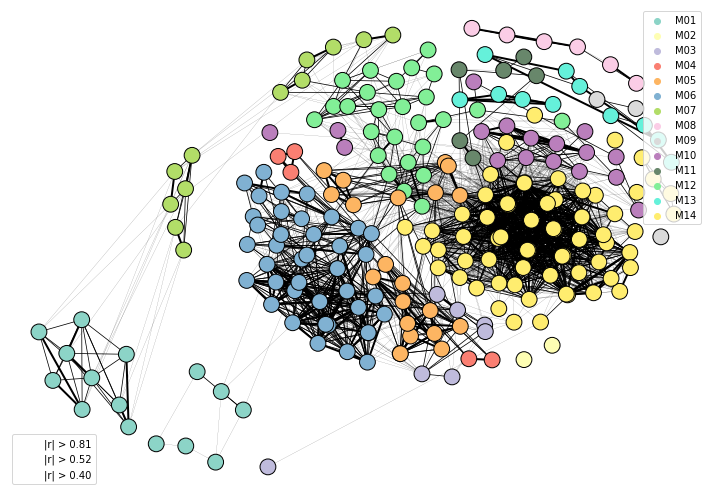

In [9]:
# Now we can re-draw network with the module colours
draw_network(mm_adj, node_color=node_colours, color_labels=module_colours, figsize=(10, 7))

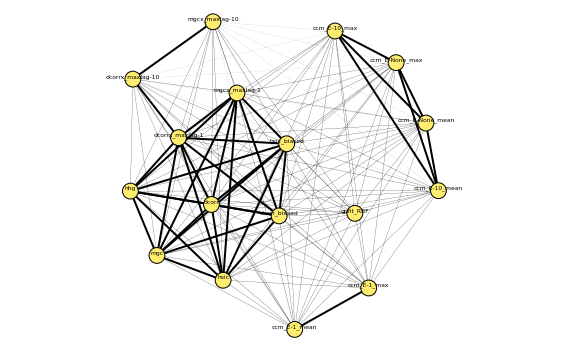

In [10]:

spi = 'dcorr' # distance correlation
cutoff = 0.5

def get_stat_cluster(spi, cutoff):
    modules = hierarchy.fcluster(Z, cutoff, criterion='distance')
    spi_mod = modules[numpy.where(statnames == spi)[0]]
    return statnames[modules == spi_mod]

stat_in_cluster = get_stat_cluster(spi, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

thresholds = (0.75,0.5,0.25)
weights = (2,0.2,0.05)

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))

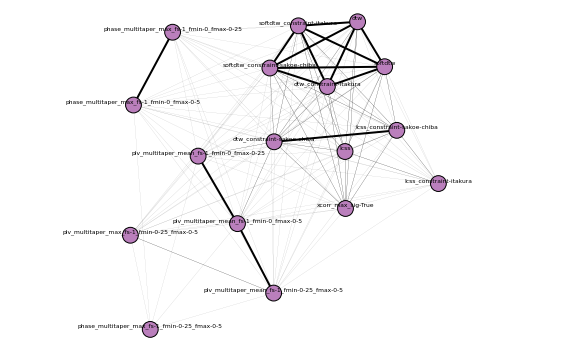

In [11]:
stat = 'lcss' # longest common subsequence
cutoff = 0.75

stat_in_cluster = get_stat_cluster(stat, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))

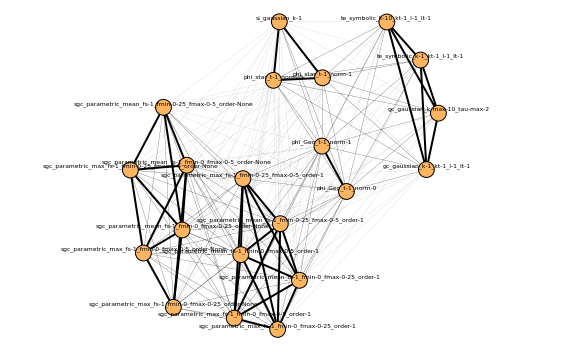

In [12]:
# Granger causality with a history length of 10 and a time delay of 2
stat = 'gc_gaussian_k-max-10_tau-max-2'
cutoff = 0.7

stat_in_cluster = get_stat_cluster(stat, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))

# Classification case study

Here, we compute all pairwise interactions on a multivariate time series (MTS) for the purpose of MTS classification.

The case study we will use is the `BasicMotions` UEA dataset, where the goal is to infer the basic movement (walking, running, standing, or playing badminton) from 3D accelerometer and 3D gyroscope data from a smart watch (i.e., a 6D MTS). 

In [13]:
scores = pandas.read_csv(f'data/spis.csv',index_col=0).dropna(how='all')
scores

,resample-0,resample-1,resample-2,resample-3,resample-4,resample-5,resample-6,resample-7,resample-8,resample-9,...,resample-20,resample-21,resample-22,resample-23,resample-24,resample-25,resample-26,resample-27,resample-28,resample-29
Statistic,,,,,,,,,,,,,,,,,,,,,
cov_EmpiricalCovariance,0.900,0.800,0.925,0.850,0.900,0.875,0.875,0.850,0.875,0.950,...,0.925,0.850,0.825,0.875,0.850,0.925,0.900,0.875,0.925,0.850
cov_EllipticEnvelope,0.850,0.850,0.875,0.850,0.925,0.925,0.850,0.850,0.925,0.925,...,0.875,0.900,0.900,0.925,0.850,0.900,0.875,0.775,0.875,0.750
cov_GraphicalLasso,0.900,0.800,0.925,0.875,0.900,0.875,0.850,0.850,0.875,0.925,...,0.925,0.825,0.800,0.875,0.850,0.925,0.900,0.875,0.850,0.850
cov_GraphicalLassoCV,0.875,0.775,0.925,0.900,0.850,0.800,0.850,0.750,0.875,0.800,...,0.875,0.825,0.800,0.775,0.850,0.925,0.725,0.825,0.825,0.850
cov_LedoitWolf,0.850,0.850,0.925,0.825,0.900,0.800,0.775,0.825,0.850,0.875,...,0.825,0.750,0.650,0.875,0.800,0.900,0.900,0.775,0.800,0.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
psi_wavelet_mean_fs-1_fmin-0_fmax-0-25_mean,0.450,0.425,0.450,0.475,0.350,0.375,0.400,0.400,0.425,0.525,...,0.475,0.500,0.400,0.400,0.400,0.350,0.325,0.500,0.425,0.400
psi_wavelet_mean_fs-1_fmin-0-25_fmax-0-5_mean,0.350,0.300,0.300,0.250,0.275,0.350,0.300,0.275,0.300,0.175,...,0.425,0.250,0.250,0.325,0.300,0.250,0.225,0.400,0.300,0.325
psi_wavelet_max_fs-1_fmin-0_fmax-0-5_max,0.200,0.275,0.275,0.200,0.225,0.325,0.150,0.300,0.400,0.275,...,0.275,0.325,0.200,0.325,0.175,0.225,0.225,0.350,0.200,0.350


In [14]:
nulls = pandas.read_csv(f'data/null.csv',index_col=0).dropna(how='all')
nulls

,resample-0,resample-1,resample-2,resample-3,resample-4,resample-5,resample-6,resample-7,resample-8,resample-9,...,resample-20,resample-21,resample-22,resample-23,resample-24,resample-25,resample-26,resample-27,resample-28,resample-29
Statistic,,,,,,,,,,,,,,,,,,,,,
cov_EmpiricalCovariance,0.225,0.350,0.250,0.200,0.125,0.175,0.150,0.300,0.250,0.250,...,0.250,0.075,0.275,0.200,0.100,0.100,0.200,0.300,0.225,0.300
cov_EllipticEnvelope,0.200,0.175,0.275,0.350,0.275,0.175,0.225,0.175,0.275,0.300,...,0.175,0.225,0.200,0.250,0.250,0.200,0.200,0.150,0.125,0.175
cov_GraphicalLasso,0.275,0.325,0.225,0.225,0.150,0.175,0.175,0.300,0.275,0.225,...,0.250,0.125,0.300,0.200,0.150,0.100,0.250,0.275,0.225,0.300
cov_GraphicalLassoCV,0.175,0.175,0.225,0.300,0.175,0.200,0.125,0.275,0.200,0.225,...,0.350,0.125,0.300,0.200,0.150,0.250,0.175,0.325,0.250,0.150
cov_LedoitWolf,0.200,0.225,0.225,0.150,0.225,0.175,0.150,0.300,0.175,0.250,...,0.350,0.175,0.275,0.200,0.250,0.150,0.175,0.350,0.250,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
psi_wavelet_mean_fs-1_fmin-0_fmax-0-25_mean,0.300,0.225,0.300,0.300,0.350,0.200,0.200,0.250,0.250,0.125,...,0.300,0.250,0.350,0.300,0.250,0.125,0.200,0.250,0.125,0.275
psi_wavelet_mean_fs-1_fmin-0-25_fmax-0-5_mean,0.250,0.125,0.125,0.250,0.325,0.225,0.150,0.200,0.150,0.175,...,0.175,0.250,0.150,0.175,0.275,0.125,0.325,0.125,0.150,0.275
psi_wavelet_max_fs-1_fmin-0_fmax-0-5_max,0.250,0.275,0.225,0.175,0.325,0.250,0.175,0.250,0.250,0.175,...,0.200,0.325,0.300,0.325,0.175,0.200,0.325,0.275,0.300,0.275


In [15]:
score_all = pandas.read_csv(f'data/all.csv',index_col=0).dropna(how='all')
score_all

,Score
resample-0,0.950
resample-1,0.825
resample-2,0.950
resample-3,1.000
resample-4,0.975
resample-5,0.975
resample-6,0.975
resample-7,0.900
resample-8,1.000
resample-9,0.975


In [16]:
# Extract the modules from the above dendrogram
lut_r = {m: c for c, m in zip(module_colours.keys(), module_colours.values())}
modules = pandas.Series(node_colours).map(lut_r)

modules.iloc[13:][modules.iloc[13:] == 'M01'] = 'M14'
modules = modules.loc[dn['ivl']]
modules.name = "module"

NameError: name 'lut' is not defined

In [ ]:
# Also extract the hand-picked category names (see appendix of the paper)
categories = pandas.read_csv('data/categories.csv', index_col=0)

spi_labels = pandas.concat([modules, categories], axis=1)
spi_labels

In [ ]:
import seaborn as sns

# Enforce an order for the categories and modules
dorder = ['causal','distance','infotheory','spectral','misc','basic','wavelet']
morder = sorted(modules.unique())

# Pretty colour maps
dcmap = sns.color_palette('pastel',len(dorder))
mcmap = [matplotlib.colors.rgb2hex(c/255+(0,)) for c in numpy.genfromtxt('data/cmap.csv', delimiter=',')]

In [ ]:
# Top 10 scores
scores.mean(axis=1).sort_values().iloc[-10:]

In [ ]:
# Bottom 10 scores
scores.mean(axis=1).sort_values().iloc[:10]

In [ ]:
import scipy.stats

vfunc = numpy.vectorize(lambda x : scipy.stats.percentileofscore(nulls.mean(axis=1), x))
pvalues = pandas.DataFrame(columns=['pvalue'], index=scores.index, data=1. - vfunc(scores.mean(axis=1)) / 100.)

bf_alpha = 0.05 / pvalues.shape[0] # Bonferroni-corrected alpha
scores["average"] = scores.mean(axis=1)
spi_score_labels = pandas.concat([spi_labels, scores], axis=1, join="inner")

all_score = score_all.mean().values[0]
null_quantile = numpy.quantile(nulls.mean(axis=1), 1 - bf_alpha)
spi_score_labels["significant"] = pvalues < bf_alpha
spi_score_labels

In [ ]:
print(f"Percent of significant scores: {100*spi_score_labels['significant'].mean():.1f}%")

In [ ]:
# Plot the histogram of scores coloured by significance (from Fisher's method)
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(data=spi_score_labels, hue='significant', x='average',
                multiple='stack', bins=20, element='step',
                stat='probability', palette='binary')
plt.axvline(null_quantile, color='k')
plt.axvline(all_score, color='r')

In [ ]:
# Plot the violin plot of the average score by category
fig, ax = plt.subplots()
sortorder = pandas.Series(['basic','distance','causal','infotheory','spectral','misc'])
cmap = numpy.array(dcmap)[sortorder.map({k: i for i, k in enumerate(dorder)})]

sns.violinplot(data=spi_score_labels, x='category', y='average',
                palette=cmap, cut=0, order=sortorder, scale='width', inner=None)

sns.stripplot(data=spi_score_labels, x='category', y='average',
                jitter=True,color='#000000',order=sortorder,alpha=0.6)
plt.axhline(null_quantile,color='k')
plt.axhline(all_score,color='r')

In [ ]:
# Plot the violin plot of the average score by module
fig, ax = plt.subplots(figsize=(7.5,5))
sortorder = spi_score_labels[['module','average']].groupby(by='module').mean().sort_values(by='average').index

sns.violinplot(data=spi_score_labels, x='module', y='average',
                palette=mcmap, cut=0, order=morder, scale='width',
                width=0.6,linewidth=1,inner=None)

sns.stripplot(data=spi_score_labels, x='module', y='average',
                jitter=True, color='#000000', order=morder, alpha=0.6)

plt.axhline(null_quantile,color='k')
plt.axhline(all_score,color='r')
plt.show()